In [3]:
import pandas as pd
from func import cal_buoyancy,sounding_cal
import glob
import os
from haversine import haversine, Unit
import re
import datetime
import metpy.calc as mpcalc
from metpy.units import units
from datetime import datetime, timedelta
from metpy import constants
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
import seaborn as sns
import tropycal.tracks as tracks
from pydoc import help
from sklearn.preprocessing import QuantileTransformer
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
from io import StringIO 
import requests
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
# Set display options to show all rows and columns in dataframe
pd.set_option('display.max_rows', None)

pd.set_option('display.max_columns', None)

In [5]:
hurdat = tracks.TrackDataset(basin='north_atlantic',source='hurdat',include_btk=False)

--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (3.31 seconds)


In [6]:
#read in precipitation files:
#2001-2019 warm-season

directory_path = "../../data/rong1/climate_fu/Data/DOEARM/sgp/abrfc_final"

#files either .cdf or .nc
#file name looks like: sgpabrfcprecipX1.c1.19971231.000000.custom.cdf
#file name looks like: sgpabrfcprecipX1.c1.20171231.000000.custom.nc

files = [
    
    os.path.join(directory_path, file)
    
    for file in os.listdir(directory_path)
    
    if file.endswith(".cdf") or file.endswith(".nc")
]

filtered_files = []

for file in files:
    
    file_name = os.path.basename(file)
    
    year_month = file_name.split('.')[2]
    
    if len(year_month) == 8:
        
        year = int(year_month[0:4])
        
        month = int(year_month[4:6])
        
        day = int(year_month[6:8])
        
        hours_mins_seconds = file_name.split('.')[3]
        
        hour = int(hours_mins_seconds[0:2])
        
        if 5 <= month <= 9 and 2001 <= year <= 2018:
            
            filtered_files.append(file)
    

precipdfs = []

for ds in sorted(filtered_files):
    
    ds = xr.open_dataset(ds)
    
    precipdfs.append(ds)
    
len(precipdfs)

2753

In [8]:
cleanp = []

for df in precipdfs:
    
    min_p = 0
    
    #equivalent to 250mm of rain per hour
    
    max_p = 25000

    precip = df.variables['precip'].data
          
    mask = ((precip < min_p) | (precip > max_p))

    precip_clean = np.where(mask, np.nan, precip)
    
    nan_count = np.count_nonzero(np.isnan(precip_clean))

    if nan_count == 0:
        
        cleanp.append(df)
        
print(len(cleanp))

2745


In [72]:
# first, identify grid points we will use for regional average of precipitation 

target_lat = 36.60

target_lon = -97.48

all_neighborhood_gridpoints = []

ds = cleanp[0]

lats = ds['lat'].data # 2 dimensional

lons = ds['lon'].data # 2 dimensional

# Loop over all grid points
for lat_idx in range(lats.shape[0] - 1):  # Prevent index out of bounds
    
    for lon_idx in range(lons.shape[1] - 1):

        sw_lat = lats[lat_idx, lon_idx]

        sw_lon = lons[lat_idx, lon_idx]

        ne_lat = lats[lat_idx + 1, lon_idx + 1]

        ne_lon = lons[lat_idx + 1, lon_idx + 1]

        # Compute center of grid box
        center_lat = (sw_lat + ne_lat) / 2
        
        center_lon = (sw_lon + ne_lon) / 2

        # Compute distance to target point
        distance = haversine((center_lat, center_lon), (target_lat, target_lon), unit='km')

        if distance <= 50:
            
            all_neighborhood_gridpoints.append((lat_idx, lon_idx))

In [73]:
ds = cleanp[0]

target_lat = all_neighborhood_gridpoints[0][0]

target_lon = all_neighborhood_gridpoints[0][1]

In [77]:
ds['lat'].data[target_lat, target_lon], ds['lon'].data[target_lat, target_lon]

(36.171, -97.701)

In [78]:
extracted_data = ds.sel(y=target_lat, x=target_lon)

extracted_data

<xarray.Dataset> Size: 3MB
Dimensions:         (time: 24, hrapy: 159, hrapx: 335, latlong: 4)
Coordinates:
  * time            (time) datetime64[ns] 192B 2001-05-01 ... 2001-05-01T23:0...
Dimensions without coordinates: hrapy, hrapx, latlong
Data variables: (12/13)
    base_time       datetime64[ns] 8B ...
    time_offset     (time) datetime64[ns] 192B ...
    precip          (time, hrapy, hrapx) int16 3MB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    timeofdata      (time) |S11 264B ...
    timeofcreation  (time) |S11 264B ...
    hrap_xor        float32 4B ...
    ...              ...
    lat_boundaries  (latlong) float32 16B ...
    lon_boundaries  (latlong) float32 16B ...
    true_lat        float32 4B ...
    true_lon        float32 4B ...
    lat             float32 4B 36.17
    lon             float32 4B -97.7
Attributes:
    Date:                created Thu Oct 11 16:16:45 2007
    Version:             $State: process-xdc-abrfc_merge-1.0-3 $
    Data_Description:    Arkansas-Red Basin River Forecast Center (ABRFC) Pre...
    Input_Platforms:     sgpabrfcpcpX1.c1
    facility_id:         X1
    site_id:             sgp
    zeb_platform:        sgpabrfcprecipX1.c1
    HRAP_Grid_comment:   The Hydrologic Rainfall Analysis Project (HRAP) grid...
    HRAP_Grid_comment2:  Note that precip is given for each cell in the HRAP ...
    comment:             For more information on ABRFC or about the HRAP grid...
    history:             Created by nco on Thu Oct 11 16:16:45 2007

In [ ]:
# calculation of regional average precipitation for every hour in time-series

num_time_steps = sum(ds['time_offset'].size for ds in cleanp)  # Total time steps across datasets

# Pre-allocate arrays

all_times = np.empty(num_time_steps, dtype='datetime64[s]')  # Assuming times are in numeric format

all_precip = np.empty(num_time_steps, dtype=np.float64)

all_precip[:] = np.nan  # Initialize precipitation array with NaNs

idx = 0  # Index for filling arrays

for ds in cleanp:

    target_lat = 36.60
    
    target_lon = -97.48
    
    # converting to mm 

    precip = ds['precip'].data / 100 # Shape: (time, lat, lon)
    
    times = ds['time_offset'].data  # Array of time offsets
    
    latitudes = ds['lat'].data
    
    longitudes = ds['lon'].data

    for t_idx, t in enumerate(times):  # Use index-based looping

        precip_50km = []

        for lat_idx in range(latitudes.shape[0] - 1):
            
            for lon_idx in range(longitudes.shape[1] - 1):

                # Get the coordinates of the corners
                sw_lat = latitudes[lat_idx, lon_idx]
                
                sw_lon = longitudes[lat_idx, lon_idx]
                
                ne_lat = latitudes[lat_idx + 1, lon_idx + 1]
                
                ne_lon = longitudes[lat_idx + 1, lon_idx + 1]

                # Calculate the center of the grid box
                center_lat = (sw_lat + ne_lat) / 2
                
                center_lon = (sw_lon + ne_lon) / 2

                # Compute distance from the target point
                distance = haversine((center_lat, center_lon), (target_lat, target_lon), unit='km')

                if distance <= 50:
                    
                    precip_50km.append(precip[t_idx, lat_idx, lon_idx])  # Use `t_idx`, not `t`

        # Compute the regional average, handling empty cases
        all_times[idx] = t
        
        all_precip[idx] = np.mean(precip_50km) if precip_50km else np.nan
        
        print(t, np.mean(precip_50km))
        
        idx += 1
        
# Trim arrays in case pre-allocation overestimated size
all_times = all_times[:idx]

all_precip = all_precip[:idx]

2001-05-01T00:00:00.000000000 0.0
2001-05-01T01:00:00.000000000 0.0
2001-05-01T02:00:00.000000000 0.0
2001-05-01T03:00:00.000000000 0.0
2001-05-01T04:00:00.000000000 0.0
2001-05-01T05:00:00.000000000 0.0
2001-05-01T06:00:00.000000000 0.0
2001-05-01T07:00:00.000000000 0.0
2001-05-01T08:00:00.000000000 0.0
2001-05-01T09:00:00.000000000 0.0
2001-05-01T10:00:00.000000000 0.0
2001-05-01T11:00:00.000000000 0.0
2001-05-01T12:00:00.000000000 0.0
2001-05-01T13:00:00.000000000 0.0
2001-05-01T14:00:00.000000000 0.0
2001-05-01T15:00:00.000000000 0.0
2001-05-01T16:00:00.000000000 0.0
2001-05-01T17:00:00.000000000 0.0
2001-05-01T18:00:00.000000000 0.0
2001-05-01T19:00:00.000000000 0.0
2001-05-01T20:00:00.000000000 0.0
2001-05-01T21:00:00.000000000 0.0
2001-05-01T22:00:00.000000000 0.0
2001-05-01T23:00:00.000000000 0.0
2001-05-02T00:00:00.000000000 0.0
2001-05-02T01:00:00.000000000 0.0
2001-05-02T02:00:00.000000000 0.0
2001-05-02T03:00:00.000000000 0.0
2001-05-02T04:00:00.000000000 0.0
2001-05-02T05:

2001-05-09T18:00:00.000000000 0.0
2001-05-09T19:00:00.000000000 0.0
2001-05-09T20:00:00.000000000 0.0
2001-05-09T21:00:00.000000000 0.0
2001-05-09T22:00:00.000000000 0.0
2001-05-09T23:00:00.000000000 0.0
2001-05-10T00:00:00.000000000 0.0
2001-05-10T01:00:00.000000000 0.0
2001-05-10T02:00:00.000000000 0.0
2001-05-10T03:00:00.000000000 0.0
2001-05-10T04:00:00.000000000 0.0
2001-05-10T05:00:00.000000000 0.0
2001-05-10T06:00:00.000000000 0.0
2001-05-10T07:00:00.000000000 0.5761603375527427
2001-05-10T08:00:00.000000000 0.7903586497890295
2001-05-10T09:00:00.000000000 0.3611814345991561
2001-05-10T10:00:00.000000000 0.505084388185654
2001-05-10T11:00:00.000000000 0.2541983122362869
2001-05-10T12:00:00.000000000 0.12054852320675105
2001-05-10T13:00:00.000000000 0.029135021097046413
2001-05-10T14:00:00.000000000 0.0012236286919831223
2001-05-10T15:00:00.000000000 0.10386075949367089
2001-05-10T16:00:00.000000000 0.07352320675105485
2001-05-10T17:00:00.000000000 0.017362869198312238
2001-05-10

2001-05-18T22:00:00.000000000 0.0
2001-05-18T23:00:00.000000000 0.0
2001-05-19T00:00:00.000000000 0.0
2001-05-19T01:00:00.000000000 0.0
2001-05-19T02:00:00.000000000 0.0
2001-05-19T03:00:00.000000000 0.0
2001-05-19T04:00:00.000000000 0.0
2001-05-19T05:00:00.000000000 0.0
2001-05-19T06:00:00.000000000 0.0
2001-05-19T07:00:00.000000000 0.0
2001-05-19T08:00:00.000000000 0.0
2001-05-19T09:00:00.000000000 0.0
2001-05-19T10:00:00.000000000 0.0
2001-05-19T11:00:00.000000000 0.0
2001-05-19T12:00:00.000000000 0.0
2001-05-19T13:00:00.000000000 0.0
2001-05-19T14:00:00.000000000 0.0
2001-05-19T15:00:00.000000000 0.0
2001-05-19T16:00:00.000000000 0.0
2001-05-19T17:00:00.000000000 0.0
2001-05-19T18:00:00.000000000 0.0
2001-05-19T19:00:00.000000000 0.0
2001-05-19T20:00:00.000000000 0.003016877637130802
2001-05-19T21:00:00.000000000 0.08447257383966243
2001-05-19T22:00:00.000000000 0.6826793248945149
2001-05-19T23:00:00.000000000 1.4471097046413501
2001-05-20T00:00:00.000000000 0.3783122362869198
2001

2001-05-28T05:00:00.000000000 0.14721518987341772
2001-05-28T06:00:00.000000000 0.0
2001-05-28T07:00:00.000000000 0.0
2001-05-28T08:00:00.000000000 0.0
2001-05-28T09:00:00.000000000 0.0
2001-05-28T10:00:00.000000000 0.013966244725738399
2001-05-28T11:00:00.000000000 0.0
2001-05-28T12:00:00.000000000 0.0
2001-05-28T13:00:00.000000000 0.0
2001-05-28T14:00:00.000000000 0.0
2001-05-28T15:00:00.000000000 0.0
2001-05-28T16:00:00.000000000 0.0
2001-05-28T17:00:00.000000000 0.0
2001-05-28T18:00:00.000000000 0.0
2001-05-28T19:00:00.000000000 0.0
2001-05-28T20:00:00.000000000 0.0
2001-05-28T21:00:00.000000000 0.0
2001-05-28T22:00:00.000000000 0.0
2001-05-28T23:00:00.000000000 0.0
2001-05-29T00:00:00.000000000 0.0
2001-05-29T01:00:00.000000000 0.0
2001-05-29T02:00:00.000000000 0.0
2001-05-29T03:00:00.000000000 0.0
2001-05-29T04:00:00.000000000 0.0
2001-05-29T05:00:00.000000000 0.0
2001-05-29T06:00:00.000000000 0.0
2001-05-29T07:00:00.000000000 0.0
2001-05-29T08:00:00.000000000 0.0
2001-05-29T09:0

2001-06-06T08:00:00.000000000 0.0
2001-06-06T09:00:00.000000000 0.0
2001-06-06T10:00:00.000000000 0.0
2001-06-06T11:00:00.000000000 0.0
2001-06-06T12:00:00.000000000 0.0
2001-06-06T13:00:00.000000000 0.0
2001-06-06T14:00:00.000000000 0.0
2001-06-06T15:00:00.000000000 0.0
2001-06-06T16:00:00.000000000 0.0
2001-06-06T17:00:00.000000000 0.0
2001-06-06T18:00:00.000000000 0.0
2001-06-06T19:00:00.000000000 0.0
2001-06-06T20:00:00.000000000 0.0
2001-06-06T21:00:00.000000000 0.0
2001-06-06T22:00:00.000000000 0.0
2001-06-06T23:00:00.000000000 0.0
2001-06-07T00:00:00.000000000 0.0
2001-06-07T01:00:00.000000000 0.0
2001-06-07T02:00:00.000000000 0.0
2001-06-07T03:00:00.000000000 0.0
2001-06-07T04:00:00.000000000 0.0
2001-06-07T05:00:00.000000000 0.0
2001-06-07T06:00:00.000000000 0.0
2001-06-07T07:00:00.000000000 0.0
2001-06-07T08:00:00.000000000 0.0
2001-06-07T09:00:00.000000000 0.0
2001-06-07T10:00:00.000000000 0.0
2001-06-07T11:00:00.000000000 0.0
2001-06-07T12:00:00.000000000 0.0
2001-06-07T13:

2001-06-15T18:00:00.000000000 0.0
2001-06-15T19:00:00.000000000 0.0
2001-06-15T20:00:00.000000000 0.0
2001-06-15T21:00:00.000000000 0.0
2001-06-15T22:00:00.000000000 0.0
2001-06-15T23:00:00.000000000 0.0
2001-06-16T00:00:00.000000000 0.0
2001-06-16T01:00:00.000000000 0.0
2001-06-16T02:00:00.000000000 0.0
2001-06-16T03:00:00.000000000 0.0
2001-06-16T04:00:00.000000000 0.0
2001-06-16T05:00:00.000000000 0.0
2001-06-16T06:00:00.000000000 0.0
2001-06-16T07:00:00.000000000 0.0
2001-06-16T08:00:00.000000000 0.0
2001-06-16T09:00:00.000000000 0.0
2001-06-16T10:00:00.000000000 0.0
2001-06-16T11:00:00.000000000 0.0
2001-06-16T12:00:00.000000000 0.0
2001-06-16T13:00:00.000000000 0.0
2001-06-16T14:00:00.000000000 0.0
2001-06-16T15:00:00.000000000 0.0
2001-06-16T16:00:00.000000000 0.0
2001-06-16T17:00:00.000000000 0.0
2001-06-16T18:00:00.000000000 0.0
2001-06-16T19:00:00.000000000 0.0
2001-06-16T20:00:00.000000000 0.0
2001-06-16T21:00:00.000000000 0.0
2001-06-16T22:00:00.000000000 0.0
2001-06-16T23:

2001-06-26T08:00:00.000000000 0.0
2001-06-26T09:00:00.000000000 0.0
2001-06-26T10:00:00.000000000 0.0
2001-06-26T11:00:00.000000000 0.0
2001-06-26T12:00:00.000000000 0.0
2001-06-26T13:00:00.000000000 0.0
2001-06-26T14:00:00.000000000 0.0
2001-06-26T15:00:00.000000000 0.0
2001-06-26T16:00:00.000000000 0.0
2001-06-26T17:00:00.000000000 0.0
2001-06-26T18:00:00.000000000 0.0
2001-06-26T19:00:00.000000000 0.0
2001-06-26T20:00:00.000000000 0.0
2001-06-26T21:00:00.000000000 0.0
2001-06-26T22:00:00.000000000 0.0
2001-06-26T23:00:00.000000000 0.0
2001-06-27T00:00:00.000000000 0.0
2001-06-27T01:00:00.000000000 0.0
2001-06-27T02:00:00.000000000 0.0
2001-06-27T03:00:00.000000000 0.0
2001-06-27T04:00:00.000000000 0.0
2001-06-27T05:00:00.000000000 0.0
2001-06-27T06:00:00.000000000 0.0
2001-06-27T07:00:00.000000000 0.0
2001-06-27T08:00:00.000000000 0.0
2001-06-27T09:00:00.000000000 0.0014135021097046415
2001-06-27T10:00:00.000000000 0.0
2001-06-27T11:00:00.000000000 0.0
2001-06-27T12:00:00.000000000 

2001-07-05T11:00:00.000000000 0.002130801687763713
2001-07-05T12:00:00.000000000 0.016434599156118144
2001-07-05T13:00:00.000000000 0.0
2001-07-05T14:00:00.000000000 0.0
2001-07-05T15:00:00.000000000 0.0
2001-07-05T16:00:00.000000000 0.0
2001-07-05T17:00:00.000000000 0.0
2001-07-05T18:00:00.000000000 0.0
2001-07-05T19:00:00.000000000 0.0
2001-07-05T20:00:00.000000000 0.0
2001-07-05T21:00:00.000000000 0.0
2001-07-05T22:00:00.000000000 0.0
2001-07-05T23:00:00.000000000 0.0
2001-07-06T00:00:00.000000000 0.0
2001-07-06T01:00:00.000000000 0.0
2001-07-06T02:00:00.000000000 0.0
2001-07-06T03:00:00.000000000 0.0
2001-07-06T04:00:00.000000000 0.0
2001-07-06T05:00:00.000000000 0.0
2001-07-06T06:00:00.000000000 0.0
2001-07-06T07:00:00.000000000 0.0
2001-07-06T08:00:00.000000000 0.0
2001-07-06T09:00:00.000000000 0.0
2001-07-06T10:00:00.000000000 0.0
2001-07-06T11:00:00.000000000 0.0
2001-07-06T12:00:00.000000000 0.0
2001-07-06T13:00:00.000000000 0.0
2001-07-06T14:00:00.000000000 0.0
2001-07-06T15:

2001-07-15T10:00:00.000000000 0.08759493670886076
2001-07-15T11:00:00.000000000 0.1049789029535865
2001-07-15T12:00:00.000000000 0.09592827004219409
2001-07-15T13:00:00.000000000 0.14453586497890294
2001-07-15T14:00:00.000000000 0.006223628691983123
2001-07-15T15:00:00.000000000 0.14002109704641352
2001-07-15T16:00:00.000000000 0.1421097046413502
2001-07-15T17:00:00.000000000 0.04067510548523207
2001-07-15T18:00:00.000000000 0.0
2001-07-15T19:00:00.000000000 0.0
2001-07-15T20:00:00.000000000 0.0
2001-07-15T21:00:00.000000000 0.0
2001-07-15T22:00:00.000000000 0.0
2001-07-15T23:00:00.000000000 0.0
2001-07-16T00:00:00.000000000 0.0
2001-07-16T01:00:00.000000000 0.0
2001-07-16T02:00:00.000000000 0.0
2001-07-16T03:00:00.000000000 0.0
2001-07-16T04:00:00.000000000 0.0
2001-07-16T05:00:00.000000000 0.0
2001-07-16T06:00:00.000000000 0.0
2001-07-16T07:00:00.000000000 0.02829113924050633
2001-07-16T08:00:00.000000000 0.018396624472573838
2001-07-16T09:00:00.000000000 2.003607594936709
2001-07-16

2001-07-25T01:00:00.000000000 0.0
2001-07-25T02:00:00.000000000 0.0
2001-07-25T03:00:00.000000000 0.0
2001-07-25T04:00:00.000000000 0.0
2001-07-25T05:00:00.000000000 0.0
2001-07-25T06:00:00.000000000 0.0
2001-07-25T07:00:00.000000000 0.0
2001-07-25T08:00:00.000000000 0.0
2001-07-25T09:00:00.000000000 0.0
2001-07-25T10:00:00.000000000 0.0
2001-07-25T11:00:00.000000000 0.0
2001-07-25T12:00:00.000000000 0.0
2001-07-25T13:00:00.000000000 0.0
2001-07-25T14:00:00.000000000 0.0
2001-07-25T15:00:00.000000000 0.0
2001-07-25T16:00:00.000000000 0.0
2001-07-25T17:00:00.000000000 0.0
2001-07-25T18:00:00.000000000 0.0
2001-07-25T19:00:00.000000000 0.0
2001-07-25T20:00:00.000000000 0.0
2001-07-25T21:00:00.000000000 0.0
2001-07-25T22:00:00.000000000 0.0
2001-07-25T23:00:00.000000000 0.0
2001-07-26T00:00:00.000000000 0.0
2001-07-26T01:00:00.000000000 0.0
2001-07-26T02:00:00.000000000 0.0
2001-07-26T03:00:00.000000000 0.013565400843881857
2001-07-26T04:00:00.000000000 0.003797468354430379
2001-07-26T05:

2001-08-03T11:00:00.000000000 0.0
2001-08-03T12:00:00.000000000 0.0
2001-08-03T13:00:00.000000000 0.0
2001-08-03T14:00:00.000000000 0.0
2001-08-03T15:00:00.000000000 0.0
2001-08-03T16:00:00.000000000 0.0
2001-08-03T17:00:00.000000000 0.0
2001-08-03T18:00:00.000000000 0.0
2001-08-03T19:00:00.000000000 0.0
2001-08-03T20:00:00.000000000 0.0
2001-08-03T21:00:00.000000000 0.0
2001-08-03T22:00:00.000000000 0.0
2001-08-03T23:00:00.000000000 0.0
2001-08-04T00:00:00.000000000 0.0
2001-08-04T01:00:00.000000000 0.0
2001-08-04T02:00:00.000000000 0.0
2001-08-04T03:00:00.000000000 0.0
2001-08-04T04:00:00.000000000 0.0
2001-08-04T05:00:00.000000000 0.0
2001-08-04T06:00:00.000000000 0.0
2001-08-04T07:00:00.000000000 0.0
2001-08-04T08:00:00.000000000 0.0
2001-08-04T09:00:00.000000000 0.0
2001-08-04T10:00:00.000000000 0.0
2001-08-04T11:00:00.000000000 0.0
2001-08-04T12:00:00.000000000 0.0
2001-08-04T13:00:00.000000000 0.0
2001-08-04T14:00:00.000000000 0.0
2001-08-04T15:00:00.000000000 0.0
2001-08-04T16:

2001-08-12T18:00:00.000000000 0.0
2001-08-12T19:00:00.000000000 0.0
2001-08-12T20:00:00.000000000 0.0
2001-08-12T21:00:00.000000000 0.0
2001-08-12T22:00:00.000000000 0.0
2001-08-12T23:00:00.000000000 0.0
2001-08-13T00:00:00.000000000 0.0
2001-08-13T01:00:00.000000000 0.0
2001-08-13T02:00:00.000000000 0.0
2001-08-13T03:00:00.000000000 0.0
2001-08-13T04:00:00.000000000 0.0
2001-08-13T05:00:00.000000000 0.0
2001-08-13T06:00:00.000000000 0.0
2001-08-13T07:00:00.000000000 0.0
2001-08-13T08:00:00.000000000 0.0
2001-08-13T09:00:00.000000000 0.0
2001-08-13T10:00:00.000000000 0.0
2001-08-13T11:00:00.000000000 0.0
2001-08-13T12:00:00.000000000 0.0
2001-08-13T13:00:00.000000000 0.0
2001-08-13T14:00:00.000000000 0.0
2001-08-13T15:00:00.000000000 0.0
2001-08-13T16:00:00.000000000 0.0
2001-08-13T17:00:00.000000000 0.0
2001-08-13T18:00:00.000000000 0.0
2001-08-13T19:00:00.000000000 0.0
2001-08-13T20:00:00.000000000 0.0
2001-08-13T21:00:00.000000000 0.0
2001-08-13T22:00:00.000000000 0.0
2001-08-13T23:

2001-08-23T12:00:00.000000000 0.0
2001-08-23T13:00:00.000000000 0.0
2001-08-23T14:00:00.000000000 0.004367088607594936
2001-08-23T15:00:00.000000000 0.0006118143459915612
2001-08-23T16:00:00.000000000 0.0
2001-08-23T17:00:00.000000000 0.0028902953586497893
2001-08-23T18:00:00.000000000 0.0
2001-08-23T19:00:00.000000000 0.0
2001-08-23T20:00:00.000000000 0.0
2001-08-23T21:00:00.000000000 0.0
2001-08-23T22:00:00.000000000 0.4598523206751054
2001-08-23T23:00:00.000000000 1.7602953586497887
2001-08-24T00:00:00.000000000 0.35837552742616036
2001-08-24T01:00:00.000000000 0.32647679324894513
2001-08-24T02:00:00.000000000 0.2101898734177215
2001-08-24T03:00:00.000000000 0.13729957805907173
2001-08-24T04:00:00.000000000 0.0032700421940928277
2001-08-24T05:00:00.000000000 0.0
2001-08-24T06:00:00.000000000 0.0015822784810126582
2001-08-24T07:00:00.000000000 0.6816877637130802
2001-08-24T08:00:00.000000000 0.1708438818565401
2001-08-24T09:00:00.000000000 0.00031645569620253165
2001-08-24T10:00:00.0

2001-09-01T16:00:00.000000000 0.0
2001-09-01T17:00:00.000000000 0.0
2001-09-01T18:00:00.000000000 0.0
2001-09-01T19:00:00.000000000 0.0
2001-09-01T20:00:00.000000000 0.0
2001-09-01T21:00:00.000000000 0.0
2001-09-01T22:00:00.000000000 0.0
2001-09-01T23:00:00.000000000 0.0
2001-09-02T00:00:00.000000000 0.0
2001-09-02T01:00:00.000000000 0.0
2001-09-02T02:00:00.000000000 0.0
2001-09-02T03:00:00.000000000 0.0
2001-09-02T04:00:00.000000000 0.0
2001-09-02T05:00:00.000000000 0.0
2001-09-02T06:00:00.000000000 0.0
2001-09-02T07:00:00.000000000 0.0
2001-09-02T08:00:00.000000000 0.0
2001-09-02T09:00:00.000000000 0.0
2001-09-02T10:00:00.000000000 0.0
2001-09-02T11:00:00.000000000 0.0
2001-09-02T12:00:00.000000000 0.0
2001-09-02T13:00:00.000000000 0.0
2001-09-02T14:00:00.000000000 0.0
2001-09-02T15:00:00.000000000 0.0
2001-09-02T16:00:00.000000000 0.0
2001-09-02T17:00:00.000000000 0.0
2001-09-02T18:00:00.000000000 0.0
2001-09-02T19:00:00.000000000 0.0
2001-09-02T20:00:00.000000000 0.0
2001-09-02T21:

2001-09-10T17:00:00.000000000 0.0
2001-09-10T18:00:00.000000000 0.0
2001-09-10T19:00:00.000000000 0.0
2001-09-10T20:00:00.000000000 0.0
2001-09-10T21:00:00.000000000 0.0
2001-09-10T22:00:00.000000000 0.0
2001-09-10T23:00:00.000000000 0.0
2001-09-11T00:00:00.000000000 0.0
2001-09-11T01:00:00.000000000 0.0
2001-09-11T02:00:00.000000000 0.0
2001-09-11T03:00:00.000000000 0.0
2001-09-11T04:00:00.000000000 0.0
2001-09-11T05:00:00.000000000 0.0
2001-09-11T06:00:00.000000000 0.0
2001-09-11T07:00:00.000000000 0.0
2001-09-11T08:00:00.000000000 0.0
2001-09-11T09:00:00.000000000 0.0
2001-09-11T10:00:00.000000000 0.0
2001-09-11T11:00:00.000000000 0.0
2001-09-11T12:00:00.000000000 0.0
2001-09-11T13:00:00.000000000 0.0
2001-09-11T14:00:00.000000000 0.0
2001-09-11T15:00:00.000000000 0.0
2001-09-11T16:00:00.000000000 0.0
2001-09-11T17:00:00.000000000 0.0
2001-09-11T18:00:00.000000000 0.0
2001-09-11T19:00:00.000000000 0.0
2001-09-11T20:00:00.000000000 0.0
2001-09-11T21:00:00.000000000 0.0
2001-09-11T22:

2001-09-19T19:00:00.000000000 0.0
2001-09-19T20:00:00.000000000 0.0
2001-09-19T21:00:00.000000000 0.0
2001-09-19T22:00:00.000000000 0.0
2001-09-19T23:00:00.000000000 0.0
2001-09-20T00:00:00.000000000 0.0
2001-09-20T01:00:00.000000000 0.0
2001-09-20T02:00:00.000000000 0.0
2001-09-20T03:00:00.000000000 0.0
2001-09-20T04:00:00.000000000 0.0
2001-09-20T05:00:00.000000000 0.0
2001-09-20T06:00:00.000000000 0.0
2001-09-20T07:00:00.000000000 0.0
2001-09-20T08:00:00.000000000 0.0
2001-09-20T09:00:00.000000000 0.0
2001-09-20T10:00:00.000000000 0.0
2001-09-20T11:00:00.000000000 0.0
2001-09-20T12:00:00.000000000 0.0
2001-09-20T13:00:00.000000000 0.23050632911392407
2001-09-20T14:00:00.000000000 0.780759493670886
2001-09-20T15:00:00.000000000 0.379873417721519
2001-09-20T16:00:00.000000000 0.8032911392405063
2001-09-20T17:00:00.000000000 0.9615400843881857
2001-09-20T18:00:00.000000000 0.12179324894514768
2001-09-20T19:00:00.000000000 0.0
2001-09-20T20:00:00.000000000 0.0
2001-09-20T21:00:00.000000

2001-09-30T08:00:00.000000000 0.0
2001-09-30T09:00:00.000000000 0.0
2001-09-30T10:00:00.000000000 0.0
2001-09-30T11:00:00.000000000 0.0
2001-09-30T12:00:00.000000000 0.0
2001-09-30T13:00:00.000000000 0.0
2001-09-30T14:00:00.000000000 0.0
2001-09-30T15:00:00.000000000 0.0
2001-09-30T16:00:00.000000000 0.0
2001-09-30T17:00:00.000000000 0.0
2001-09-30T18:00:00.000000000 0.0
2001-09-30T19:00:00.000000000 0.0
2001-09-30T20:00:00.000000000 0.0
2001-09-30T21:00:00.000000000 0.0
2001-09-30T22:00:00.000000000 0.0
2001-09-30T23:00:00.000000000 0.0
2002-05-01T00:00:00.000000000 0.0
2002-05-01T01:00:00.000000000 0.0
2002-05-01T02:00:00.000000000 0.0
2002-05-01T03:00:00.000000000 0.0
2002-05-01T04:00:00.000000000 0.0
2002-05-01T05:00:00.000000000 0.0
2002-05-01T06:00:00.000000000 0.0
2002-05-01T07:00:00.000000000 0.0
2002-05-01T08:00:00.000000000 0.0
2002-05-01T09:00:00.000000000 0.0
2002-05-01T10:00:00.000000000 0.0
2002-05-01T11:00:00.000000000 0.0
2002-05-01T12:00:00.000000000 0.0
2002-05-01T14:

2002-05-10T03:00:00.000000000 0.0
2002-05-10T04:00:00.000000000 0.0
2002-05-10T05:00:00.000000000 0.0
2002-05-10T06:00:00.000000000 0.0
2002-05-10T07:00:00.000000000 0.0
2002-05-10T08:00:00.000000000 0.0
2002-05-10T09:00:00.000000000 0.0
2002-05-10T10:00:00.000000000 0.0
2002-05-10T11:00:00.000000000 0.0
2002-05-10T12:00:00.000000000 0.0
2002-05-10T13:00:00.000000000 0.0
2002-05-10T14:00:00.000000000 0.0
2002-05-10T15:00:00.000000000 0.0
2002-05-10T16:00:00.000000000 0.0
2002-05-10T17:00:00.000000000 0.0
2002-05-10T18:00:00.000000000 0.3260126582278481
2002-05-10T19:00:00.000000000 2.9521940928270047
2002-05-10T20:00:00.000000000 1.8640295358649788
2002-05-10T21:00:00.000000000 0.1367932489451477
2002-05-10T22:00:00.000000000 0.03757383966244725
2002-05-10T23:00:00.000000000 0.0
2002-05-11T00:00:00.000000000 0.0
2002-05-11T01:00:00.000000000 0.0
2002-05-11T02:00:00.000000000 0.0
2002-05-11T03:00:00.000000000 0.0
2002-05-11T04:00:00.000000000 0.0
2002-05-11T05:00:00.000000000 0.0
2002-0

2002-05-19T11:00:00.000000000 0.0
2002-05-19T12:00:00.000000000 0.0
2002-05-19T13:00:00.000000000 0.0
2002-05-19T14:00:00.000000000 0.0
2002-05-19T15:00:00.000000000 0.0
2002-05-19T16:00:00.000000000 0.0
2002-05-19T17:00:00.000000000 0.0
2002-05-19T18:00:00.000000000 0.0
2002-05-19T19:00:00.000000000 0.0
2002-05-19T20:00:00.000000000 0.0
2002-05-19T21:00:00.000000000 0.0
2002-05-19T22:00:00.000000000 0.0
2002-05-19T23:00:00.000000000 0.0
2002-05-20T00:00:00.000000000 0.0
2002-05-20T01:00:00.000000000 0.0
2002-05-20T02:00:00.000000000 0.0
2002-05-20T03:00:00.000000000 0.0
2002-05-20T04:00:00.000000000 0.0
2002-05-20T05:00:00.000000000 0.0
2002-05-20T06:00:00.000000000 0.027489451476793252
2002-05-20T07:00:00.000000000 0.14375527426160334
2002-05-20T08:00:00.000000000 0.07116033755274262
2002-05-20T09:00:00.000000000 0.05858649789029536
2002-05-20T10:00:00.000000000 0.03377637130801688
2002-05-20T11:00:00.000000000 0.03210970464135021
2002-05-20T12:00:00.000000000 0.11135021097046416
200

2002-05-28T03:00:00.000000000 0.0
2002-05-28T04:00:00.000000000 0.0020464135021097045
2002-05-28T05:00:00.000000000 0.0
2002-05-28T06:00:00.000000000 0.0
2002-05-28T07:00:00.000000000 0.0028902953586497893
2002-05-28T08:00:00.000000000 0.0
2002-05-28T09:00:00.000000000 0.0
2002-05-28T10:00:00.000000000 0.0
2002-05-28T11:00:00.000000000 0.005210970464135021
2002-05-28T12:00:00.000000000 0.4859493670886076
2002-05-28T13:00:00.000000000 0.18343881856540084
2002-05-28T14:00:00.000000000 0.4325949367088608
2002-05-28T15:00:00.000000000 0.0869198312236287
2002-05-28T16:00:00.000000000 0.015295358649789027
2002-05-28T17:00:00.000000000 0.03354430379746835
2002-05-28T18:00:00.000000000 0.18191983122362868
2002-05-28T19:00:00.000000000 0.7396413502109704
2002-05-28T20:00:00.000000000 0.33759493670886076
2002-05-28T21:00:00.000000000 0.041118143459915615
2002-05-28T22:00:00.000000000 0.03383966244725738
2002-05-28T23:00:00.000000000 0.03367088607594937
2002-05-29T00:00:00.000000000 0.0
2002-05-2

2002-06-06T08:00:00.000000000 0.0
2002-06-06T09:00:00.000000000 0.0
2002-06-06T10:00:00.000000000 0.0
2002-06-06T11:00:00.000000000 0.0
2002-06-06T12:00:00.000000000 0.0
2002-06-06T13:00:00.000000000 0.0
2002-06-06T14:00:00.000000000 0.0
2002-06-06T15:00:00.000000000 0.0
2002-06-06T16:00:00.000000000 0.0
2002-06-06T17:00:00.000000000 0.0
2002-06-06T18:00:00.000000000 0.0
2002-06-06T19:00:00.000000000 0.0
2002-06-06T20:00:00.000000000 0.0
2002-06-06T21:00:00.000000000 0.0
2002-06-06T22:00:00.000000000 0.0
2002-06-06T23:00:00.000000000 0.0
2002-06-07T00:00:00.000000000 0.0
2002-06-07T01:00:00.000000000 0.0
2002-06-07T02:00:00.000000000 0.0
2002-06-07T03:00:00.000000000 0.0
2002-06-07T04:00:00.000000000 0.0
2002-06-07T05:00:00.000000000 0.0
2002-06-07T06:00:00.000000000 0.0
2002-06-07T07:00:00.000000000 0.0
2002-06-07T08:00:00.000000000 0.0006118143459915612
2002-06-07T09:00:00.000000000 0.0
2002-06-07T10:00:00.000000000 0.0
2002-06-07T11:00:00.000000000 0.0
2002-06-07T12:00:00.000000000 

2002-06-16T08:00:00.000000000 0.0
2002-06-16T09:00:00.000000000 0.0
2002-06-16T10:00:00.000000000 0.0
2002-06-16T11:00:00.000000000 0.0
2002-06-16T12:00:00.000000000 0.0
2002-06-16T13:00:00.000000000 0.0
2002-06-16T14:00:00.000000000 0.0
2002-06-16T15:00:00.000000000 0.0
2002-06-16T16:00:00.000000000 0.0
2002-06-16T17:00:00.000000000 0.0
2002-06-16T18:00:00.000000000 0.0
2002-06-16T19:00:00.000000000 0.0
2002-06-16T20:00:00.000000000 0.0
2002-06-16T21:00:00.000000000 0.0
2002-06-16T22:00:00.000000000 0.0
2002-06-16T23:00:00.000000000 0.0
2002-06-17T00:00:00.000000000 0.0
2002-06-17T01:00:00.000000000 0.0
2002-06-17T02:00:00.000000000 0.0
2002-06-17T03:00:00.000000000 0.0
2002-06-17T04:00:00.000000000 0.0
2002-06-17T05:00:00.000000000 0.0
2002-06-17T06:00:00.000000000 0.0
2002-06-17T07:00:00.000000000 0.0
2002-06-17T08:00:00.000000000 0.0
2002-06-17T09:00:00.000000000 0.0
2002-06-17T10:00:00.000000000 0.0
2002-06-17T11:00:00.000000000 0.0
2002-06-17T12:00:00.000000000 0.0
2002-06-17T13:

2002-06-26T07:00:00.000000000 0.0
2002-06-26T08:00:00.000000000 0.0
2002-06-26T09:00:00.000000000 0.0
2002-06-26T10:00:00.000000000 0.0
2002-06-26T11:00:00.000000000 0.0
2002-06-26T12:00:00.000000000 0.0
2002-06-26T13:00:00.000000000 0.0
2002-06-26T14:00:00.000000000 0.0
2002-06-26T15:00:00.000000000 0.0
2002-06-26T16:00:00.000000000 0.0
2002-06-26T17:00:00.000000000 0.0
2002-06-26T18:00:00.000000000 0.0
2002-06-26T19:00:00.000000000 0.0
2002-06-26T20:00:00.000000000 0.0
2002-06-26T21:00:00.000000000 0.0
2002-06-26T22:00:00.000000000 0.0
2002-06-26T23:00:00.000000000 0.0
2002-06-27T00:00:00.000000000 0.0
2002-06-27T01:00:00.000000000 0.0
2002-06-27T02:00:00.000000000 0.0
2002-06-27T03:00:00.000000000 0.0
2002-06-27T04:00:00.000000000 0.0
2002-06-27T05:00:00.000000000 0.0
2002-06-27T06:00:00.000000000 0.0
2002-06-27T07:00:00.000000000 0.0
2002-06-27T08:00:00.000000000 0.0
2002-06-27T09:00:00.000000000 0.0
2002-06-27T10:00:00.000000000 0.0
2002-06-27T11:00:00.000000000 0.0
2002-06-27T12:

2002-07-05T10:00:00.000000000 0.0
2002-07-05T11:00:00.000000000 0.0
2002-07-05T12:00:00.000000000 0.0
2002-07-05T13:00:00.000000000 0.0
2002-07-05T14:00:00.000000000 0.0
2002-07-05T15:00:00.000000000 0.0
2002-07-05T16:00:00.000000000 0.0
2002-07-05T17:00:00.000000000 0.0
2002-07-05T18:00:00.000000000 0.0
2002-07-05T19:00:00.000000000 0.0
2002-07-05T20:00:00.000000000 0.0
2002-07-05T21:00:00.000000000 0.0
2002-07-05T22:00:00.000000000 0.0
2002-07-05T23:00:00.000000000 0.0
2002-07-06T00:00:00.000000000 0.0
2002-07-06T01:00:00.000000000 0.0
2002-07-06T02:00:00.000000000 0.0
2002-07-06T03:00:00.000000000 0.0
2002-07-06T04:00:00.000000000 0.0
2002-07-06T05:00:00.000000000 0.0
2002-07-06T06:00:00.000000000 0.0
2002-07-06T07:00:00.000000000 0.0
2002-07-06T08:00:00.000000000 0.0
2002-07-06T09:00:00.000000000 0.0
2002-07-06T10:00:00.000000000 0.0
2002-07-06T11:00:00.000000000 0.0
2002-07-06T12:00:00.000000000 0.0
2002-07-06T13:00:00.000000000 0.0
2002-07-06T14:00:00.000000000 0.0
2002-07-06T15:

2002-07-14T07:00:00.000000000 0.0
2002-07-14T08:00:00.000000000 0.0
2002-07-14T09:00:00.000000000 0.0
2002-07-14T10:00:00.000000000 0.0
2002-07-14T11:00:00.000000000 0.0
2002-07-14T12:00:00.000000000 0.0
2002-07-14T13:00:00.000000000 0.0
2002-07-14T14:00:00.000000000 0.0
2002-07-14T15:00:00.000000000 0.0
2002-07-14T16:00:00.000000000 0.0
2002-07-14T17:00:00.000000000 0.0
2002-07-14T18:00:00.000000000 0.0
2002-07-14T19:00:00.000000000 0.0
2002-07-14T20:00:00.000000000 0.0
2002-07-14T21:00:00.000000000 0.0
2002-07-14T22:00:00.000000000 0.0
2002-07-14T23:00:00.000000000 0.0
2002-07-15T00:00:00.000000000 0.0
2002-07-15T01:00:00.000000000 0.0
2002-07-15T02:00:00.000000000 0.0
2002-07-15T03:00:00.000000000 0.0
2002-07-15T04:00:00.000000000 0.0
2002-07-15T05:00:00.000000000 0.0
2002-07-15T06:00:00.000000000 0.0
2002-07-15T07:00:00.000000000 0.0
2002-07-15T08:00:00.000000000 0.0
2002-07-15T09:00:00.000000000 0.0
2002-07-15T10:00:00.000000000 0.0
2002-07-15T11:00:00.000000000 0.0
2002-07-15T12:

2002-07-23T12:00:00.000000000 0.02548523206751055
2002-07-23T13:00:00.000000000 0.0
2002-07-23T14:00:00.000000000 0.0
2002-07-23T15:00:00.000000000 0.009430379746835443
2002-07-23T16:00:00.000000000 0.0
2002-07-23T17:00:00.000000000 0.0
2002-07-23T18:00:00.000000000 0.0
2002-07-23T19:00:00.000000000 0.0
2002-07-23T20:00:00.000000000 0.0
2002-07-23T21:00:00.000000000 0.0
2002-07-23T22:00:00.000000000 0.0
2002-07-23T23:00:00.000000000 0.0
2002-07-24T00:00:00.000000000 0.0
2002-07-24T01:00:00.000000000 0.0
2002-07-24T02:00:00.000000000 0.0
2002-07-24T03:00:00.000000000 0.0
2002-07-24T04:00:00.000000000 0.018502109704641348
2002-07-24T05:00:00.000000000 0.07841772151898735
2002-07-24T06:00:00.000000000 0.03710970464135021
2002-07-24T07:00:00.000000000 0.0
2002-07-24T08:00:00.000000000 0.0
2002-07-24T09:00:00.000000000 0.0
2002-07-24T10:00:00.000000000 0.0
2002-07-24T11:00:00.000000000 0.0
2002-07-24T12:00:00.000000000 0.0
2002-07-24T13:00:00.000000000 0.0
2002-07-24T14:00:00.000000000 0.0


2002-08-01T23:00:00.000000000 0.020232067510548523
2002-08-02T00:00:00.000000000 0.25008438818565404
2002-08-02T01:00:00.000000000 0.2868354430379747
2002-08-02T02:00:00.000000000 0.11888185654008439
2002-08-02T03:00:00.000000000 0.0006118143459915612
2002-08-02T04:00:00.000000000 0.0
2002-08-02T05:00:00.000000000 0.0
2002-08-02T06:00:00.000000000 0.0
2002-08-02T07:00:00.000000000 0.0
2002-08-02T08:00:00.000000000 0.0
2002-08-02T09:00:00.000000000 0.0
2002-08-02T10:00:00.000000000 0.0
2002-08-02T11:00:00.000000000 0.0
2002-08-02T12:00:00.000000000 0.0
2002-08-02T13:00:00.000000000 0.0
2002-08-02T14:00:00.000000000 0.0
2002-08-02T15:00:00.000000000 0.0
2002-08-02T16:00:00.000000000 0.0
2002-08-02T17:00:00.000000000 0.0
2002-08-02T18:00:00.000000000 0.0
2002-08-02T19:00:00.000000000 0.013607594936708859
2002-08-02T20:00:00.000000000 0.22105485232067507
2002-08-02T21:00:00.000000000 0.19905063291139238
2002-08-02T22:00:00.000000000 0.3949367088607595
2002-08-02T23:00:00.000000000 0.191329

2002-08-11T10:00:00.000000000 0.0
2002-08-11T11:00:00.000000000 0.0
2002-08-11T12:00:00.000000000 0.0
2002-08-11T13:00:00.000000000 0.0
2002-08-11T14:00:00.000000000 0.0
2002-08-11T15:00:00.000000000 0.0
2002-08-11T16:00:00.000000000 0.0
2002-08-11T17:00:00.000000000 0.0
2002-08-11T18:00:00.000000000 0.0
2002-08-11T19:00:00.000000000 0.0
2002-08-11T20:00:00.000000000 0.0
2002-08-11T21:00:00.000000000 0.0
2002-08-11T22:00:00.000000000 0.0
2002-08-11T23:00:00.000000000 0.0
2002-08-12T00:00:00.000000000 0.0
2002-08-12T01:00:00.000000000 0.0
2002-08-12T02:00:00.000000000 0.0
2002-08-12T03:00:00.000000000 0.0
2002-08-12T04:00:00.000000000 0.0
2002-08-12T05:00:00.000000000 0.0
2002-08-12T06:00:00.000000000 0.0
2002-08-12T07:00:00.000000000 0.0
2002-08-12T08:00:00.000000000 0.15833333333333335
2002-08-12T09:00:00.000000000 6.0216877637130795
2002-08-12T10:00:00.000000000 8.049451476793248
2002-08-12T11:00:00.000000000 1.9509915611814346
2002-08-12T12:00:00.000000000 1.2773206751054853
2002-08

2002-08-20T17:00:00.000000000 0.0
2002-08-20T18:00:00.000000000 0.0
2002-08-20T19:00:00.000000000 0.0
2002-08-20T20:00:00.000000000 0.0
2002-08-20T21:00:00.000000000 0.0
2002-08-20T22:00:00.000000000 0.0
2002-08-20T23:00:00.000000000 0.0
2002-08-21T00:00:00.000000000 0.0
2002-08-21T01:00:00.000000000 0.0
2002-08-21T02:00:00.000000000 0.0
2002-08-21T03:00:00.000000000 0.0
2002-08-21T04:00:00.000000000 0.0
2002-08-21T05:00:00.000000000 0.0
2002-08-21T06:00:00.000000000 0.002679324894514768
2002-08-21T07:00:00.000000000 0.01350210970464135
2002-08-21T08:00:00.000000000 0.050864978902953585
2002-08-21T09:00:00.000000000 0.001983122362869198
2002-08-21T10:00:00.000000000 0.06732067510548524
2002-08-21T11:00:00.000000000 1.4151476793248945
2002-08-21T12:00:00.000000000 0.7138396624472574
2002-08-21T13:00:00.000000000 2.053902953586498
2002-08-21T14:00:00.000000000 4.764008438818566
2002-08-21T15:00:00.000000000 0.7579535864978902
2002-08-21T16:00:00.000000000 0.24516877637130802
2002-08-21T1

2002-08-29T15:00:00.000000000 0.0
2002-08-29T16:00:00.000000000 0.0
2002-08-29T17:00:00.000000000 0.0
2002-08-29T18:00:00.000000000 0.0
2002-08-29T19:00:00.000000000 0.0
2002-08-29T20:00:00.000000000 0.0
2002-08-29T21:00:00.000000000 0.0
2002-08-29T22:00:00.000000000 0.0
2002-08-29T23:00:00.000000000 0.0
2002-08-30T00:00:00.000000000 0.0
2002-08-30T01:00:00.000000000 0.0
2002-08-30T02:00:00.000000000 0.0
2002-08-30T03:00:00.000000000 0.0
2002-08-30T04:00:00.000000000 0.0
2002-08-30T05:00:00.000000000 0.0
2002-08-30T06:00:00.000000000 0.0
2002-08-30T07:00:00.000000000 0.0
2002-08-30T08:00:00.000000000 0.0
2002-08-30T09:00:00.000000000 0.0
2002-08-30T10:00:00.000000000 0.0
2002-08-30T11:00:00.000000000 0.0
2002-08-30T12:00:00.000000000 0.0
2002-08-30T13:00:00.000000000 0.0
2002-08-30T14:00:00.000000000 0.0
2002-08-30T15:00:00.000000000 0.0
2002-08-30T16:00:00.000000000 0.0
2002-08-30T17:00:00.000000000 0.0
2002-08-30T18:00:00.000000000 0.0
2002-08-30T19:00:00.000000000 0.0
2002-08-30T20:

2002-09-08T15:00:00.000000000 0.0
2002-09-08T16:00:00.000000000 0.0
2002-09-08T17:00:00.000000000 0.0
2002-09-08T18:00:00.000000000 0.0
2002-09-08T19:00:00.000000000 0.0
2002-09-08T20:00:00.000000000 0.0
2002-09-08T21:00:00.000000000 0.0
2002-09-08T22:00:00.000000000 0.01839662447257384
2002-09-08T23:00:00.000000000 0.0
2002-09-09T00:00:00.000000000 0.0
2002-09-09T01:00:00.000000000 0.0
2002-09-09T02:00:00.000000000 0.0
2002-09-09T03:00:00.000000000 0.0
2002-09-09T04:00:00.000000000 0.0
2002-09-09T05:00:00.000000000 0.0
2002-09-09T06:00:00.000000000 0.0
2002-09-09T07:00:00.000000000 0.0
2002-09-09T08:00:00.000000000 0.056392405063291136
2002-09-09T09:00:00.000000000 0.19767932489451476
2002-09-09T10:00:00.000000000 0.07552742616033754
2002-09-09T11:00:00.000000000 0.13858649789029534
2002-09-09T12:00:00.000000000 0.820759493670886
2002-09-09T13:00:00.000000000 0.6483544303797467
2002-09-09T14:00:00.000000000 1.0391772151898735
2002-09-09T15:00:00.000000000 0.055168776371308015
2002-09-

2002-09-17T14:00:00.000000000 0.0
2002-09-17T15:00:00.000000000 0.0
2002-09-17T16:00:00.000000000 0.0
2002-09-17T17:00:00.000000000 0.0
2002-09-17T18:00:00.000000000 0.0
2002-09-17T19:00:00.000000000 0.0
2002-09-17T20:00:00.000000000 0.0
2002-09-17T21:00:00.000000000 0.0
2002-09-17T22:00:00.000000000 0.0
2002-09-17T23:00:00.000000000 0.0
2002-09-18T00:00:00.000000000 0.0
2002-09-18T01:00:00.000000000 0.0
2002-09-18T02:00:00.000000000 0.0
2002-09-18T03:00:00.000000000 0.0
2002-09-18T04:00:00.000000000 0.0
2002-09-18T05:00:00.000000000 0.0
2002-09-18T06:00:00.000000000 0.0
2002-09-18T07:00:00.000000000 0.035801687763713085
2002-09-18T08:00:00.000000000 0.06255274261603375
2002-09-18T09:00:00.000000000 0.0
2002-09-18T10:00:00.000000000 0.0
2002-09-18T11:00:00.000000000 0.0
2002-09-18T12:00:00.000000000 0.0
2002-09-18T13:00:00.000000000 0.0
2002-09-18T14:00:00.000000000 0.0
2002-09-18T15:00:00.000000000 0.0
2002-09-18T16:00:00.000000000 0.0
2002-09-18T17:00:00.000000000 0.0
2002-09-18T18:0

2002-09-27T05:00:00.000000000 0.0
2002-09-27T06:00:00.000000000 0.0
2002-09-27T07:00:00.000000000 0.0
2002-09-27T08:00:00.000000000 0.0
2002-09-27T09:00:00.000000000 0.0
2002-09-27T10:00:00.000000000 0.0
2002-09-27T11:00:00.000000000 0.0
2002-09-27T12:00:00.000000000 0.0
2002-09-27T13:00:00.000000000 0.0
2002-09-27T14:00:00.000000000 0.0
2002-09-27T15:00:00.000000000 0.0
2002-09-27T16:00:00.000000000 0.0
2002-09-27T17:00:00.000000000 0.0
2002-09-27T18:00:00.000000000 0.0
2002-09-27T19:00:00.000000000 0.0
2002-09-27T20:00:00.000000000 0.0
2002-09-27T21:00:00.000000000 0.0
2002-09-27T22:00:00.000000000 0.0
2002-09-27T23:00:00.000000000 0.0
2002-09-28T00:00:00.000000000 0.0
2002-09-28T01:00:00.000000000 0.0
2002-09-28T02:00:00.000000000 0.0
2002-09-28T03:00:00.000000000 0.0
2002-09-28T04:00:00.000000000 0.0
2002-09-28T05:00:00.000000000 0.0
2002-09-28T06:00:00.000000000 0.0
2002-09-28T07:00:00.000000000 0.0
2002-09-28T08:00:00.000000000 0.0
2002-09-28T09:00:00.000000000 0.0
2002-09-28T10:

2003-05-07T01:00:00.000000000 0.0
2003-05-07T02:00:00.000000000 0.0
2003-05-07T03:00:00.000000000 0.0
2003-05-07T04:00:00.000000000 0.0
2003-05-07T05:00:00.000000000 0.0
2003-05-07T06:00:00.000000000 0.0
2003-05-07T07:00:00.000000000 0.0
2003-05-07T08:00:00.000000000 0.0
2003-05-07T09:00:00.000000000 0.0
2003-05-07T10:00:00.000000000 0.0
2003-05-07T11:00:00.000000000 0.0
2003-05-07T12:00:00.000000000 0.0
2003-05-07T13:00:00.000000000 0.0
2003-05-07T14:00:00.000000000 0.0
2003-05-07T15:00:00.000000000 0.0
2003-05-07T16:00:00.000000000 0.0
2003-05-07T17:00:00.000000000 0.0
2003-05-07T18:00:00.000000000 0.0
2003-05-07T19:00:00.000000000 0.0
2003-05-07T20:00:00.000000000 0.0
2003-05-07T21:00:00.000000000 0.0
2003-05-07T22:00:00.000000000 0.0
2003-05-07T23:00:00.000000000 0.0
2003-05-08T00:00:00.000000000 0.0
2003-05-08T01:00:00.000000000 0.0
2003-05-08T02:00:00.000000000 0.0
2003-05-08T03:00:00.000000000 0.0
2003-05-08T04:00:00.000000000 0.0
2003-05-08T05:00:00.000000000 0.0128902953586497

2003-05-16T09:00:00.000000000 13.026814345991559
2003-05-16T10:00:00.000000000 0.728270042194093
2003-05-16T11:00:00.000000000 0.1278902953586498
2003-05-16T12:00:00.000000000 0.02681434599156118
2003-05-16T13:00:00.000000000 0.017151898734177214
2003-05-16T14:00:00.000000000 0.02666666666666667
2003-05-16T15:00:00.000000000 0.05742616033755275
2003-05-16T16:00:00.000000000 0.26044303797468354
2003-05-16T17:00:00.000000000 0.5883755274261603
2003-05-16T18:00:00.000000000 1.634704641350211
2003-05-16T19:00:00.000000000 2.706434599156118
2003-05-16T20:00:00.000000000 2.628059071729958
2003-05-16T21:00:00.000000000 2.01584388185654
2003-05-16T22:00:00.000000000 0.8237341772151898
2003-05-16T23:00:00.000000000 0.1728691983122363
2003-05-17T00:00:00.000000000 0.04786919831223628
2003-05-17T01:00:00.000000000 0.07031645569620253
2003-05-17T02:00:00.000000000 0.02561181434599156
2003-05-17T03:00:00.000000000 0.029324894514767934
2003-05-17T04:00:00.000000000 0.03383966244725738
2003-05-17T05:

2003-05-25T02:00:00.000000000 0.0
2003-05-25T03:00:00.000000000 0.0
2003-05-25T04:00:00.000000000 0.0
2003-05-25T05:00:00.000000000 0.0
2003-05-25T06:00:00.000000000 0.0
2003-05-25T07:00:00.000000000 0.0
2003-05-25T08:00:00.000000000 0.0
2003-05-25T09:00:00.000000000 0.0
2003-05-25T10:00:00.000000000 0.0
2003-05-25T11:00:00.000000000 0.0
2003-05-25T12:00:00.000000000 0.0
2003-05-25T13:00:00.000000000 0.0
2003-05-25T14:00:00.000000000 0.0
2003-05-25T15:00:00.000000000 0.0
2003-05-25T16:00:00.000000000 0.0
2003-05-25T17:00:00.000000000 0.0
2003-05-25T18:00:00.000000000 0.0
2003-05-25T19:00:00.000000000 0.0
2003-05-25T20:00:00.000000000 0.0
2003-05-25T21:00:00.000000000 0.0
2003-05-25T22:00:00.000000000 0.0
2003-05-25T23:00:00.000000000 0.0
2003-05-26T00:00:00.000000000 0.0
2003-05-26T01:00:00.000000000 0.0
2003-05-26T02:00:00.000000000 0.0
2003-05-26T03:00:00.000000000 0.0
2003-05-26T04:00:00.000000000 0.0
2003-05-26T05:00:00.000000000 0.0
2003-05-26T06:00:00.000000000 0.0
2003-05-26T07:

2003-06-03T18:00:00.000000000 0.0
2003-06-03T19:00:00.000000000 0.0
2003-06-03T20:00:00.000000000 0.0
2003-06-03T21:00:00.000000000 0.0
2003-06-03T22:00:00.000000000 0.0
2003-06-03T23:00:00.000000000 0.0014556962025316458
2003-06-04T00:00:00.000000000 0.003481012658227848
2003-06-04T01:00:00.000000000 0.0059915611814345985
2003-06-04T02:00:00.000000000 0.010063291139240505
2003-06-04T03:00:00.000000000 0.0
2003-06-04T04:00:00.000000000 0.0
2003-06-04T05:00:00.000000000 0.0
2003-06-04T06:00:00.000000000 0.0
2003-06-04T07:00:00.000000000 0.0
2003-06-04T08:00:00.000000000 0.0
2003-06-04T09:00:00.000000000 0.0
2003-06-04T10:00:00.000000000 0.0030379746835443038
2003-06-04T11:00:00.000000000 0.008649789029535865
2003-06-04T12:00:00.000000000 0.0
2003-06-04T13:00:00.000000000 0.0
2003-06-04T14:00:00.000000000 0.0008438818565400844
2003-06-04T15:00:00.000000000 0.0
2003-06-04T16:00:00.000000000 0.0
2003-06-04T17:00:00.000000000 0.0
2003-06-04T18:00:00.000000000 0.009873417721518988
2003-06-04

2003-06-12T10:00:00.000000000 0.017215189873417722
2003-06-12T11:00:00.000000000 0.0
2003-06-12T12:00:00.000000000 0.010569620253164557
2003-06-12T13:00:00.000000000 0.029092827004219408
2003-06-12T14:00:00.000000000 0.06713080168776371
2003-06-12T15:00:00.000000000 0.1856329113924051
2003-06-12T16:00:00.000000000 0.6953375527426161
2003-06-12T17:00:00.000000000 0.28377637130801686
2003-06-12T18:00:00.000000000 0.029198312236286925
2003-06-12T19:00:00.000000000 0.0
2003-06-12T20:00:00.000000000 0.0
2003-06-12T21:00:00.000000000 0.0
2003-06-12T22:00:00.000000000 0.0
2003-06-12T23:00:00.000000000 0.0
2003-06-13T00:00:00.000000000 0.0
2003-06-13T01:00:00.000000000 0.0
2003-06-13T02:00:00.000000000 0.0
2003-06-13T03:00:00.000000000 0.0
2003-06-13T04:00:00.000000000 0.0
2003-06-13T05:00:00.000000000 0.0
2003-06-13T06:00:00.000000000 0.0
2003-06-13T07:00:00.000000000 0.0
2003-06-13T08:00:00.000000000 0.0
2003-06-13T09:00:00.000000000 0.0
2003-06-13T10:00:00.000000000 0.0
2003-06-13T11:00:00.

In [174]:
def is_ape(precip, times, latitude, longitude):
    
    # put arrays into a df 
    
    df = pd.DataFrame({'precip': precip, 'time': times})
    
    df['date'] = df['time'].dt.date
    
    df['hour'] = df['time'].dt.hour
    
    # adjusting times so that the 0th hour is labeled as the 24th of the previous day
    # purpose is to calculate evening precipitation more easily 
    
    df.loc[df['hour'] == 0, 'hour'] = 24
    
    df.loc[df['hour'] == 24, 'date'] = df['date'] - pd.Timedelta(days=1)

    results = []
    
    for date, group in df.groupby('date'):
        
        num_hours = len(group['hour'].values)
        
        if num_hours == 24:
        
            group = group.reset_index(drop=True)

            morning_precip = group[(group['hour'] >= 6) & (group['hour'] <= 13)]['precip'].sum()

            afternoon_precip = group[(group['hour'] >= 14) & (group['hour'] <= 20)]['precip'].sum()

            evening_precip = group[(group['hour'] >= 21) & (group['hour'] <= 24)]['precip'].sum()

            condition_1 = afternoon_precip >= 2 * morning_precip

            condition_2 = afternoon_precip > evening_precip

            peak_hour = group.iloc[group['precip'].idxmax()]['hour']

            peak_in_afternoon = 14 <= peak_hour <= 20 

            condition_3 = peak_in_afternoon 

            daily_precip = group['precip'].values 

            if condition_1 and condition_2 and condition_3:

                results.append((date, lat, lon, True, daily_precip, np.nan))

            else:

                failed_conditions = []

                if not condition_1:

                    failed_conditions.append("morning precipitation < 2x afternoon precipitation")

                if not condition_2: 

                    failed_conditions.append("afternoon precipitation < evening precipitation: ")

                if not condition_3: 

                    failed_conditions.append("peak precipitation hour not in afternoon")

                results.append((date, lat, lon, False, daily_precip, failed_conditions))
                
        else: 
                        
            results.append((date, lat, lon, False, np.nan, "not enough hours to determine"))

    return results

In [175]:
armbe_cf_apes = is_ape(precip, times, lat, lon)

apes = pd.DataFrame(armbe_cf_apes, columns=['date', 'lat','lon','APE', 'daily_precip', 'reason_for_fail'])

np.sum(apes['APE'])

169

In [181]:
apes.head(100)

,date,lat,lon,APE,daily_precip,reason_for_fail
0,2001-04-30,36,-97.5,False,NaN,not enough hours to determine
1,2001-05-01,36,-97.5,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[afternoon precipitation < evening precipitati...
2,2001-05-02,36,-97.5,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[afternoon precipitation < evening precipitati...
3,2001-05-03,36,-97.5,False,"[0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[morning precipitation < 2x afternoon precipit...
4,2001-05-04,36,-97.5,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[peak precipitation hour not in afternoon]
5,2001-05-05,36,-97.5,False,"[0.0, 0.0, 0.91, 0.0, 0.0, 0.23, 0.26, 0.0, 0....",[morning precipitation < 2x afternoon precipit...
6,2001-05-06,36,-97.5,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
7,2001-05-07,36,-97.5,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[afternoon precipitation < evening precipitati...
8,2001-05-08,36,-97.5,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[afternoon precipitation < evening precipitati...
9,2001-05-09,36,-97.5,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[afternoon precipitation < evening precipitati...


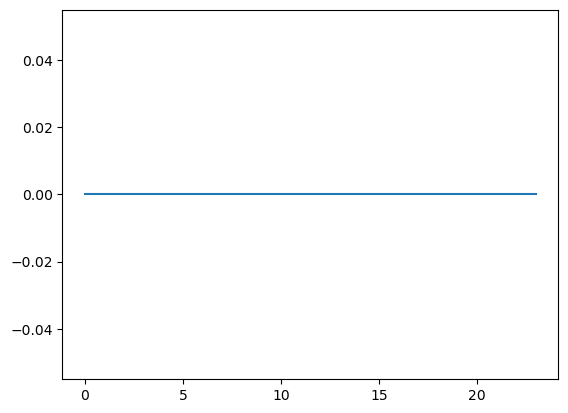

In [189]:
plt.plot(apes['daily_precip'].iloc[94])
plt.show()